In [1]:
import numpy
import os
import PIL.Image
import re
import scipy.ndimage


def load_data(printed=True, handwritten=True, lowercase_letters=True, uppercase_letters=True,
              digits=True, merge_letter_classes="all", data_dir="data"):

    # there are three options to merge letter classes...
    # "all" : default, treats lowercase and uppercase letters of the same character as the
    #         same class
    # "some": for some characters, treats the lowercase and uppercase of that character as the
    #         same class (these characters are recommended by EMNIST because their lowercase
    #         and uppercase version look alike: C, I, J, K, L, M, O, P, S, U, V, W, X, Y, Z)
    # "none": treats lowercase and uppercase letters of the same character as different
    #         classes
    assert merge_letter_classes in ["all", "some", "none"]

    DIGIT_CLASSES = list(range(10))  # class labels for digit characters
    UPPERCASE_LETTER_CLASSES = list(range(10, 36))  # class labels for uppercase letter characters
    LOWERCASE_LETTER_CLASSES = list(range(36, 62))  # class labels for lowercase letter characters

    # indexes of letters that are recommended by EMNIST that their uppercase and lowercase
    # classes be merged due to their similarity (C, I, J, K, L, M, O, P, S, U, V, W, X, Y, Z)
    EMNIST_BY_MERGE_CLASSES = (2, 8, 9, 10, 11, 12, 14, 15, 18, 20, 21, 22, 23, 24, 25)

    CLASS_DIR_NAME_FORMAT = "Sample{:03d}"  # format of each class directory name

    RE_IMG_FILE_NAME = re.compile(r"img\d{3}-(\d{5})\.png$")  # format of each image file name

    PRINTED_IMGS_PER_CLASS = 1016  # number of printed images per class

    HANDWRITTEN_IMG_DIMS = (28, 28)  # dimensions of images of handwritten characters
    PRINTED_IMG_DIMS = (128, 128)  # dimension of images of printed characters

    MAX_PIXEL_VALUE = 255.0  # maximum pixel value used in the gray scale images
    
    BORDER_PADDING = 2  # width in pixels of the forced border padding when reducing size of image


    def _get_class_labels_to_load():
        """
        Determines which class labels to load given the input of whether to load digits,
        uppercase letters, and lowercase letters.
        """
        class_labels_to_load = []
        if digits:
            class_labels_to_load.extend(DIGIT_CLASSES)
        if uppercase_letters:
            class_labels_to_load.extend(UPPERCASE_LETTER_CLASSES)
        if lowercase_letters:
            class_labels_to_load.extend(LOWERCASE_LETTER_CLASSES)
        return class_labels_to_load

    def _create_merge_and_condense_labels_map(class_labels_to_load):
        """
        Creates a map that maps raw class labels to normalized class labels by merging class
        labels given the input of how to merge lowercase/uppercase letter classes and
        condensing class labels to be a sequence starting at 0.
        """
        merge_map = {}
        if lowercase_letters and uppercase_letters and merge_letter_classes != "none":
            letter_classes = zip(LOWERCASE_LETTER_CLASSES, UPPERCASE_LETTER_CLASSES)
            if merge_letter_classes == "all":
                merge_map = dict(letter_classes)
            elif merge_letter_classes == "some":
                merge_map = dict((
                    c for i, c in enumerate(letter_classes) if i in EMNIST_BY_MERGE_CLASSES
                ))
        merged_labels_to_load = sorted({
            merge_map.get(label, label) for label in class_labels_to_load
        })
        condense_map = {label: index for index, label in enumerate(merged_labels_to_load)}
        merge_and_condense_labels_map = {
            l: condense_map[merge_map.get(l, l)] for l in class_labels_to_load
        }
        return merge_and_condense_labels_map

    def _get_class_directory(class_label):
        """
        Returns the name of a character class directory given the character class label.
        """
        # the class labels start at 0, while the class directories start with 1
        return os.path.join(data_dir, CLASS_DIR_NAME_FORMAT.format(class_label + 1))

    def _set_split(class_label, class_dir):
        printed_test_indices = numpy.random.permutation(PRINTED_IMGS_PER_CLASS)[:153] + 1
        handwritten_imgs_in_class = len(list(os.listdir(class_dir))) - PRINTED_IMGS_PER_CLASS
        handwritten_train_indices = numpy.random.permutation(
            handwritten_imgs_in_class
        )[:] + PRINTED_IMGS_PER_CLASS + 1
        return printed_test_indices, handwritten_train_indices

    def _get_image_file_number(img_file_name):
        """
        Extracts the image file number from the given image file name.
        """
        return int(RE_IMG_FILE_NAME.match(img_file_name).group(1))

    def _should_load_image(img_file_num, handwritten_train):
        """
        Determines whether the image file name with the given file number (and given
        the input of whether to load printed and handwritten images) should be loaded.
        """
        # all images of printed characters have smaller file numbers than all images of
        # handwritten characters and there are the same number of images of printed characters
        # in each class directory
        should_load_printed = img_file_num <= PRINTED_IMGS_PER_CLASS and printed
        should_load_handwritten = img_file_num in handwritten_train and handwritten
        return should_load_printed or should_load_handwritten

    def _get_image_file_path(class_dir, img_file_name):
        """
        Returns the full image file path given the class directory and the file name.
        """
        return os.path.join(class_dir, img_file_name)

    def _convert_pixel_array_to_matrix(pixel_array):
        """
        Converts a PIL.Image to a numpy.ndarray with the correct type and dimensions.
        """
        cols, rows = pixel_array.size
        return numpy.array(pixel_array, dtype=numpy.float64).reshape((rows, cols))

    def _load_image(img_file_path):
        """
        Loads an image into a matrix of pixels given the image's full file path.
        """
        pixel_array = PIL.Image.open(img_file_path)
        pixel_matrix = _convert_pixel_array_to_matrix(pixel_array)
        return pixel_matrix

    def _is_printed(pixel_matrix):
        """
        Determines whether a raw image is of a printed character given the dimensions of the
        image.
        """
        return pixel_matrix.shape == PRINTED_IMG_DIMS

    def _apply_gaussian_filter(pixel_matrix):
        """
        Applies a Gaussian filter with sigma=1 to the image.
        """
        return scipy.ndimage.gaussian_filter(pixel_matrix, sigma=1)

    def _remove_whitespace(pixel_matrix):
        """
        Crops the image so all surrounding whitespace is removed.
        """
        # the gray scale is reversed to accomodate the PIL Image library's bounding box
        # function
        negative_pixel_matrix = MAX_PIXEL_VALUE - pixel_matrix
        negative_pixel_array = PIL.Image.fromarray(negative_pixel_matrix)
        min_col, min_row, max_col, max_row = negative_pixel_array.getbbox()
        pixel_matrix = pixel_matrix[min_row:max_row, min_col:max_col]
        return pixel_matrix

    """
    Reduces pixel values in an image that are greater than the maximum pixel value allowed to
    the maximum pixel value allowed.
    """
    _reduce_pixel_values_over_max = numpy.vectorize(
        lambda pixel_value: min(pixel_value, MAX_PIXEL_VALUE)
    )

    def _center_image_in_square(pixel_matrix):
        """
        Centers the image in square dimensions where the shorter dimension (width or height)
        is increased to match the longer dimension, while preserving aspect ratio (only
        whitespace is added).
        """
        rows, cols = pixel_matrix.shape
        longer_dim = max(pixel_matrix.shape)
        square_dims = (longer_dim, longer_dim)
        # when an odd number of pixels need to be added to force a square shape of the image,
        # add an extra column of whitespace pixels to the right of the character if columns
        # need to be added to the image and add an extra row of whitespace pixels above the
        # character if rows need to be added to the image
        pixel_to_start_paste = (
            int(numpy.floor((longer_dim - cols) / 2)),
            int(numpy.ceil((longer_dim - rows) / 2))
        )
        pixel_array = PIL.Image.fromarray(pixel_matrix)
        # paste the image given as input centered over a square image of whitespace pixels
        square_pixel_array = PIL.Image.new("F", square_dims, color=MAX_PIXEL_VALUE)
        square_pixel_array.paste(pixel_array, box=pixel_to_start_paste)
        square_pixel_matrix = _convert_pixel_array_to_matrix(square_pixel_array)
        return square_pixel_matrix

    def _add_border_padding(pixel_matrix):
        """
        Adds a fixed padding around the border of the image.
        """
        rows, cols = pixel_matrix.shape
        col_padding = numpy.full((BORDER_PADDING, rows), MAX_PIXEL_VALUE)
        pixel_matrix = numpy.concatenate((col_padding, pixel_matrix, col_padding), axis=0)
        row_padding = numpy.full((cols + (2*BORDER_PADDING), BORDER_PADDING), MAX_PIXEL_VALUE)
        pixel_matrix = numpy.concatenate((row_padding, pixel_matrix, row_padding), axis=1)
        return pixel_matrix

    def _downsample_image(pixel_matrix):
        """
        Downsamples the image to the target dimensions using bi-cubic interpolation.
        """
        pixel_array = PIL.Image.fromarray(pixel_matrix)
        pixel_array = pixel_array.resize(HANDWRITTEN_IMG_DIMS, resample=PIL.Image.BICUBIC)
        pixel_matrix = _convert_pixel_array_to_matrix(pixel_array)
        # the resampling operation a couple lines above can result in some pixel values being
        # greater than the maximum pixel value allowed
        pixel_matrix = _reduce_pixel_values_over_max(pixel_matrix)
        return pixel_matrix

    def _scale_pixel_values(pixel_matrix):
        """
        Scales the pixel values of an image to a range of 0 to 1.
        """
        return pixel_matrix / MAX_PIXEL_VALUE

    def _is_train(img_file_num, printed_test, handwritten_train):
        if img_file_num <= PRINTED_IMGS_PER_CLASS:
            return img_file_num not in printed_test
        else:
            return img_file_num in handwritten_train


    train_images, test_images = [], []
    train_labels, test_labels = [], []

    class_labels_to_load = _get_class_labels_to_load()
    merge_and_condense_labels_map = _create_merge_and_condense_labels_map(class_labels_to_load)

    for class_label in class_labels_to_load:
        class_dir = _get_class_directory(class_label)
        mapped_class_label = merge_and_condense_labels_map[class_label]
        printed_test, handwritten_train = _set_split(class_label, class_dir)
        for img_file_name in os.listdir(class_dir):
            img_file_num = _get_image_file_number(img_file_name)
            if _should_load_image(img_file_num, handwritten_train):
                img_file_path = _get_image_file_path(class_dir, img_file_name)
                pixel_matrix = _load_image(img_file_path)
                if _is_printed(pixel_matrix):
                    # follows the process EMNIST used to convert 128x128 pixel NIST images to
                    # 28x28 pixel images that closely align with the MNIST standard image
                    # format; the process is outlined at the top of page 4 in this paper
                    # (https://arxiv.org/pdf/1702.05373v2.pdf)
                    pixel_matrix = _apply_gaussian_filter(pixel_matrix)
                    pixel_matrix = _remove_whitespace(pixel_matrix)
                    pixel_matrix = _center_image_in_square(pixel_matrix)
                    pixel_matrix = _add_border_padding(pixel_matrix)
                    pixel_matrix = _downsample_image(pixel_matrix)
                pixel_matrix = _scale_pixel_values(MAX_PIXEL_VALUE - pixel_matrix)

                if _is_train(img_file_num, printed_test, handwritten_train):
                    train_images.append(pixel_matrix)
                    train_labels.append(mapped_class_label)
                else:
                    test_images.append(pixel_matrix)
                    test_labels.append(mapped_class_label)


    train_images, test_images = numpy.array(train_images), numpy.array(test_images)
    train_labels, test_labels = numpy.array(train_labels), numpy.array(test_labels)

    return train_images, test_images, train_labels, test_labels

In [2]:
train_images, test_images, train_labels, test_labels = load_data(
    handwritten=False,
    digits=False,
)

In [3]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(26, activation=tf.nn.softmax),
])

In [4]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [5]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
44876/44876 [==============================] - 7s 167us/step - loss: 0.6530 - acc: 0.8347
Epoch 2/5
44876/44876 [==============================] - 7s 154us/step - loss: 0.3599 - acc: 0.9027
Epoch 3/5
44876/44876 [==============================] - 7s 156us/step - loss: 0.2717 - acc: 0.9244
Epoch 4/5
44876/44876 [==============================] - 8s 179us/step - loss: 0.2158 - acc: 0.9388
Epoch 5/5
44876/44876 [==============================] - 8s 170us/step - loss: 0.1767 - acc: 0.9485


In [6]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

7956/7956 [==============================] - 1s 69us/step
Test accuracy: 0.9365258923782782


In [7]:
import matplotlib.pyplot as plt

def _show_image(pixel_matrix):
    plt.figure()
    plt.imshow(pixel_matrix)
    plt.colorbar()
    plt.grid(False)
    plt.show()

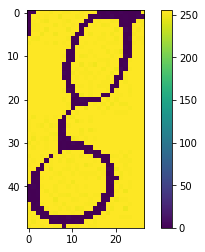

G


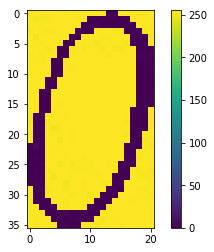

O


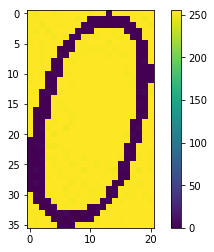

O


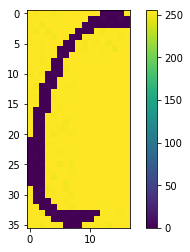

C


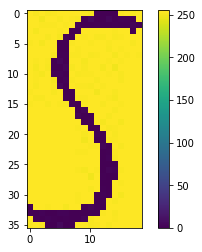

S


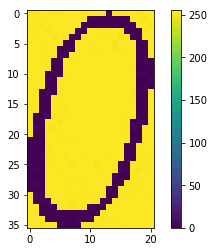

O


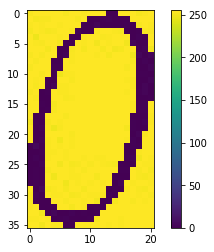

O


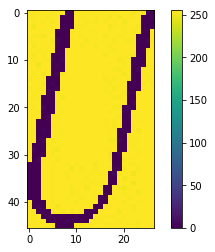

Y


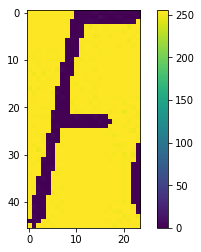

F


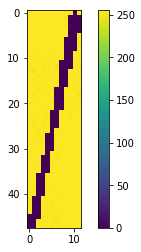

I


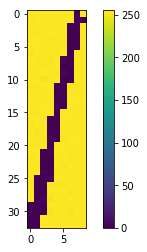

L


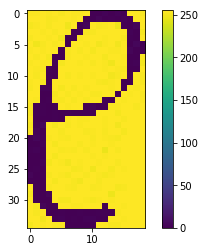

E


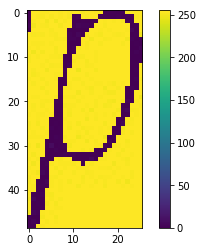

P


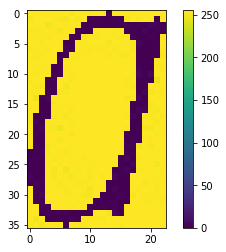

A


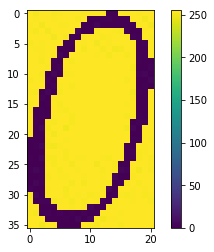

O


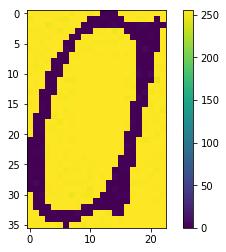

O


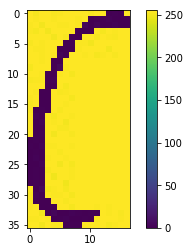

C


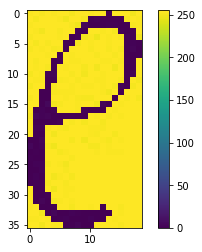

E


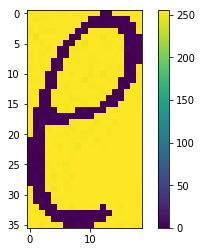

E


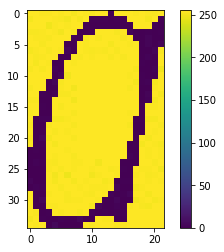

O


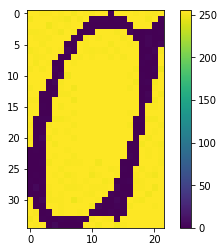

O


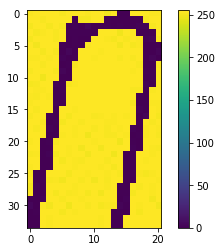

N


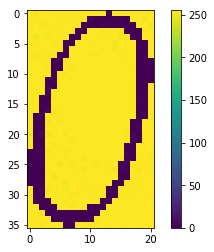

O


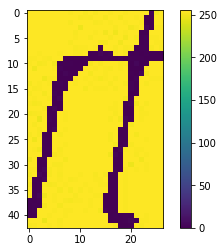

N


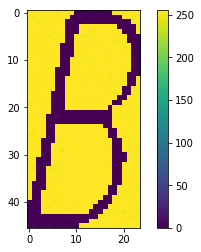

B


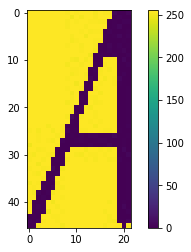

A


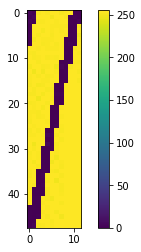

I


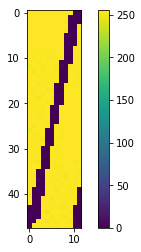

L


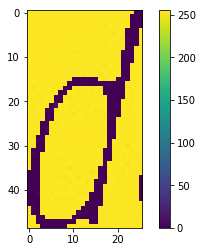

D


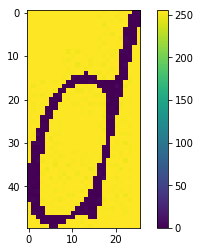

D


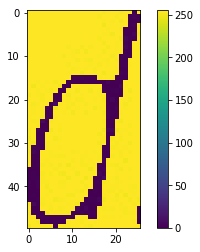

D


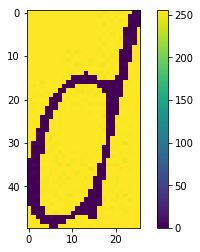

D


In [9]:
HANDWRITTEN_IMG_DIMS = (28, 28)  # dimensions of images of handwritten characters

MAX_PIXEL_VALUE = 255.0  # maximum pixel value used in the gray scale images

BORDER_PADDING = 2  # width in pixels of the forced border padding when reducing size of image

def _convert_pixel_array_to_matrix(pixel_array):
    """
    Converts a PIL.Image to a numpy.ndarray with the correct type and dimensions.
    """
    cols, rows = pixel_array.size
    return numpy.array(pixel_array, dtype=numpy.float64).reshape((rows, cols))

"""
Reduces pixel values in an image that are greater than the maximum pixel value allowed to
the maximum pixel value allowed.
"""
_reduce_pixel_values_over_max = numpy.vectorize(
    lambda pixel_value: min(pixel_value, MAX_PIXEL_VALUE)
)

def _load_image(img_file_path):
    """
    Loads an image into a matrix of pixels given the image's full file path.
    """
    pixel_array = PIL.Image.open(img_file_path)
    pixel_matrix = _convert_pixel_array_to_matrix(pixel_array)
    return pixel_matrix

def _apply_gaussian_filter(pixel_matrix):
    """
    Applies a Gaussian filter with sigma=1 to the image.
    """
    return scipy.ndimage.gaussian_filter(pixel_matrix, sigma=1)

def _remove_whitespace(pixel_matrix):
    """
    Crops the image so all surrounding whitespace is removed.
    """
    # the gray scale is reversed to accomodate the PIL Image library's bounding box
    # function
    negative_pixel_matrix = MAX_PIXEL_VALUE - pixel_matrix
    negative_pixel_array = PIL.Image.fromarray(negative_pixel_matrix)
    min_col, min_row, max_col, max_row = negative_pixel_array.getbbox()
    pixel_matrix = pixel_matrix[min_row:max_row, min_col:max_col]
    return pixel_matrix

def _center_image_in_square(pixel_matrix):
    """
    Centers the image in square dimensions where the shorter dimension (width or height)
    is increased to match the longer dimension, while preserving aspect ratio (only
    whitespace is added).
    """
    rows, cols = pixel_matrix.shape
    longer_dim = max(pixel_matrix.shape)
    square_dims = (longer_dim, longer_dim)
    # when an odd number of pixels need to be added to force a square shape of the image,
    # add an extra column of whitespace pixels to the right of the character if columns
    # need to be added to the image and add an extra row of whitespace pixels above the
    # character if rows need to be added to the image
    pixel_to_start_paste = (
        int(numpy.floor((longer_dim - cols) / 2)),
        int(numpy.ceil((longer_dim - rows) / 2))
    )
    pixel_array = PIL.Image.fromarray(pixel_matrix)
    # paste the image given as input centered over a square image of whitespace pixels
    square_pixel_array = PIL.Image.new("F", square_dims, color=MAX_PIXEL_VALUE)
    square_pixel_array.paste(pixel_array, box=pixel_to_start_paste)
    square_pixel_matrix = _convert_pixel_array_to_matrix(square_pixel_array)
    return square_pixel_matrix

def _add_border_padding(pixel_matrix):
    """
    Adds a fixed padding around the border of the image.
    """
    rows, cols = pixel_matrix.shape
    col_padding = numpy.full((BORDER_PADDING, rows), MAX_PIXEL_VALUE)
    pixel_matrix = numpy.concatenate((col_padding, pixel_matrix, col_padding), axis=0)
    row_padding = numpy.full((cols + (2*BORDER_PADDING), BORDER_PADDING), MAX_PIXEL_VALUE)
    pixel_matrix = numpy.concatenate((row_padding, pixel_matrix, row_padding), axis=1)
    return pixel_matrix

def _downsample_image(pixel_matrix):
    """
    Downsamples the image to the target dimensions using bi-cubic interpolation.
    """
    pixel_array = PIL.Image.fromarray(pixel_matrix)
    pixel_array = pixel_array.resize(HANDWRITTEN_IMG_DIMS, resample=PIL.Image.BICUBIC)
    pixel_matrix = _convert_pixel_array_to_matrix(pixel_array)
    # the resampling operation a couple lines above can result in some pixel values being
    # greater than the maximum pixel value allowed
    pixel_matrix = _reduce_pixel_values_over_max(pixel_matrix)
    return pixel_matrix

def _scale_pixel_values(pixel_matrix):
    """
    Scales the pixel values of an image to a range of 0 to 1.
    """
    return pixel_matrix / MAX_PIXEL_VALUE

real_test_images = []
for img_file in sorted(os.listdir("blur_cropped_imgs/x")):
    if img_file.endswith(".jpg"):
        img_file_path = os.path.join("blur_cropped_imgs/x", img_file)
        pixel_matrix = _load_image(img_file_path)
        pixel_matrix = _apply_gaussian_filter(MAX_PIXEL_VALUE - pixel_matrix)
        pixel_matrix = _remove_whitespace(pixel_matrix)
        pixel_matrix = _center_image_in_square(pixel_matrix)
        pixel_matrix = _add_border_padding(pixel_matrix)
        pixel_matrix = _downsample_image(pixel_matrix)
        pixel_matrix = _scale_pixel_values(MAX_PIXEL_VALUE - pixel_matrix)
        real_test_images.append(pixel_matrix)

real_test_images = numpy.array(real_test_images)

predictions = model.predict(real_test_images)

for i, img_file in enumerate(sorted(os.listdir("blur_cropped_imgs/x"))):
    img_file_path = os.path.join("blur_cropped_imgs/x", img_file)
    pixel_matrix = _load_image(img_file_path)
    _show_image(MAX_PIXEL_VALUE - pixel_matrix)
    print("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[numpy.argmax(predictions[i])])

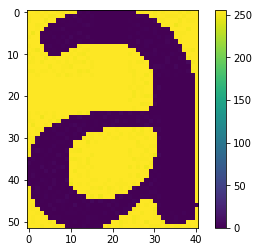

A


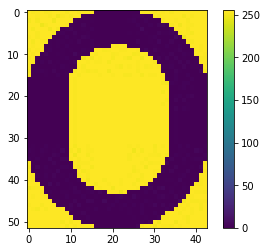

O


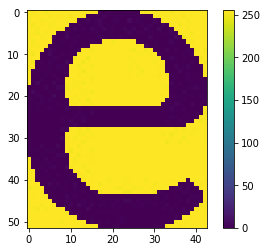

E


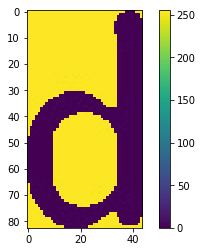

D


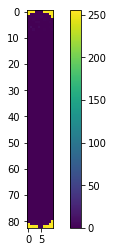

I


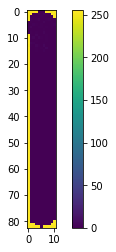

I


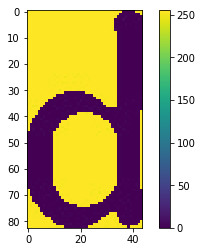

D


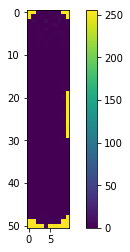

I


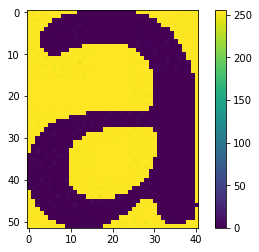

A


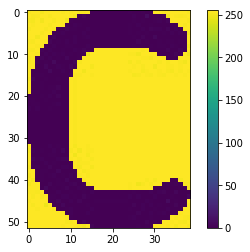

C


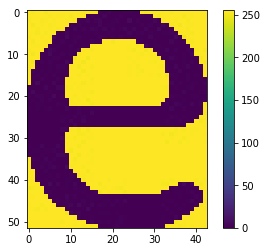

E


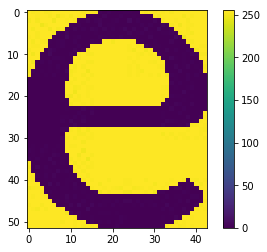

E


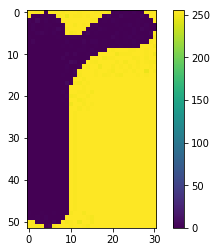

R


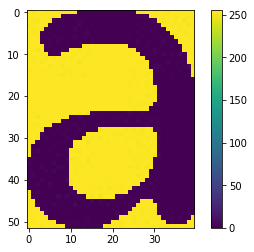

A


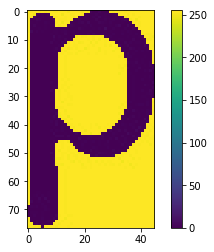

P


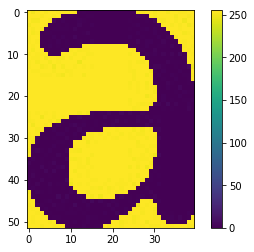

A


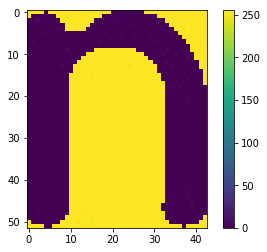

N


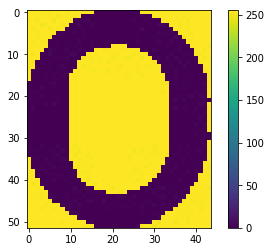

O


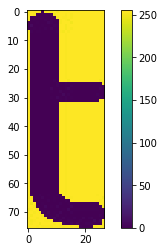

R


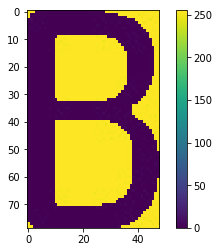

B


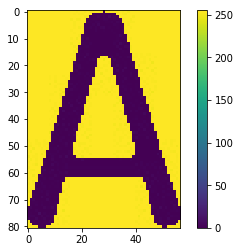

A


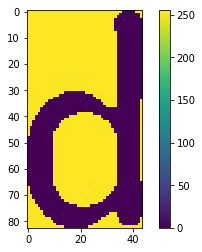

D


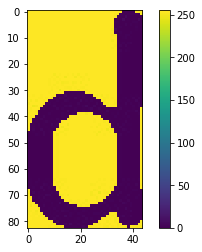

D


In [10]:
HANDWRITTEN_IMG_DIMS = (28, 28)  # dimensions of images of handwritten characters

MAX_PIXEL_VALUE = 255.0  # maximum pixel value used in the gray scale images

BORDER_PADDING = 2  # width in pixels of the forced border padding when reducing size of image

def _convert_pixel_array_to_matrix(pixel_array):
    """
    Converts a PIL.Image to a numpy.ndarray with the correct type and dimensions.
    """
    cols, rows = pixel_array.size
    return numpy.array(pixel_array, dtype=numpy.float64).reshape((rows, cols))

"""
Reduces pixel values in an image that are greater than the maximum pixel value allowed to
the maximum pixel value allowed.
"""
_reduce_pixel_values_over_max = numpy.vectorize(
    lambda pixel_value: min(pixel_value, MAX_PIXEL_VALUE)
)

def _load_image(img_file_path):
    """
    Loads an image into a matrix of pixels given the image's full file path.
    """
    pixel_array = PIL.Image.open(img_file_path)
    pixel_matrix = _convert_pixel_array_to_matrix(pixel_array)
    return pixel_matrix

def _apply_gaussian_filter(pixel_matrix):
    """
    Applies a Gaussian filter with sigma=1 to the image.
    """
    return scipy.ndimage.gaussian_filter(pixel_matrix, sigma=1)

def _remove_whitespace(pixel_matrix):
    """
    Crops the image so all surrounding whitespace is removed.
    """
    # the gray scale is reversed to accomodate the PIL Image library's bounding box
    # function
    negative_pixel_matrix = MAX_PIXEL_VALUE - pixel_matrix
    negative_pixel_array = PIL.Image.fromarray(negative_pixel_matrix)
    min_col, min_row, max_col, max_row = negative_pixel_array.getbbox()
    pixel_matrix = pixel_matrix[min_row:max_row, min_col:max_col]
    return pixel_matrix

def _center_image_in_square(pixel_matrix):
    """
    Centers the image in square dimensions where the shorter dimension (width or height)
    is increased to match the longer dimension, while preserving aspect ratio (only
    whitespace is added).
    """
    rows, cols = pixel_matrix.shape
    longer_dim = max(pixel_matrix.shape)
    square_dims = (longer_dim, longer_dim)
    # when an odd number of pixels need to be added to force a square shape of the image,
    # add an extra column of whitespace pixels to the right of the character if columns
    # need to be added to the image and add an extra row of whitespace pixels above the
    # character if rows need to be added to the image
    pixel_to_start_paste = (
        int(numpy.floor((longer_dim - cols) / 2)),
        int(numpy.ceil((longer_dim - rows) / 2))
    )
    pixel_array = PIL.Image.fromarray(pixel_matrix)
    # paste the image given as input centered over a square image of whitespace pixels
    square_pixel_array = PIL.Image.new("F", square_dims, color=MAX_PIXEL_VALUE)
    square_pixel_array.paste(pixel_array, box=pixel_to_start_paste)
    square_pixel_matrix = _convert_pixel_array_to_matrix(square_pixel_array)
    return square_pixel_matrix

def _add_border_padding(pixel_matrix):
    """
    Adds a fixed padding around the border of the image.
    """
    rows, cols = pixel_matrix.shape
    col_padding = numpy.full((BORDER_PADDING, rows), MAX_PIXEL_VALUE)
    pixel_matrix = numpy.concatenate((col_padding, pixel_matrix, col_padding), axis=0)
    row_padding = numpy.full((cols + (2*BORDER_PADDING), BORDER_PADDING), MAX_PIXEL_VALUE)
    pixel_matrix = numpy.concatenate((row_padding, pixel_matrix, row_padding), axis=1)
    return pixel_matrix

def _downsample_image(pixel_matrix):
    """
    Downsamples the image to the target dimensions using bi-cubic interpolation.
    """
    pixel_array = PIL.Image.fromarray(pixel_matrix)
    pixel_array = pixel_array.resize(HANDWRITTEN_IMG_DIMS, resample=PIL.Image.BICUBIC)
    pixel_matrix = _convert_pixel_array_to_matrix(pixel_array)
    # the resampling operation a couple lines above can result in some pixel values being
    # greater than the maximum pixel value allowed
    pixel_matrix = _reduce_pixel_values_over_max(pixel_matrix)
    return pixel_matrix

def _scale_pixel_values(pixel_matrix):
    """
    Scales the pixel values of an image to a range of 0 to 1.
    """
    return pixel_matrix / MAX_PIXEL_VALUE

real_test_images = []
for img_file in sorted(os.listdir("blur_cropped_imgs/k")):
    if img_file.endswith(".jpg"):
        img_file_path = os.path.join("blur_cropped_imgs/k", img_file)
        pixel_matrix = _load_image(img_file_path)
        pixel_matrix = _apply_gaussian_filter(MAX_PIXEL_VALUE - pixel_matrix)
        pixel_matrix = _remove_whitespace(pixel_matrix)
        pixel_matrix = _center_image_in_square(pixel_matrix)
        pixel_matrix = _add_border_padding(pixel_matrix)
        pixel_matrix = _downsample_image(pixel_matrix)
        pixel_matrix = _scale_pixel_values(MAX_PIXEL_VALUE - pixel_matrix)
        real_test_images.append(pixel_matrix)

real_test_images = numpy.array(real_test_images)

predictions = model.predict(real_test_images)

for i, img_file in enumerate(sorted(os.listdir("blur_cropped_imgs/k"))):
    img_file_path = os.path.join("blur_cropped_imgs/k", img_file)
    pixel_matrix = _load_image(img_file_path)
    _show_image(MAX_PIXEL_VALUE - pixel_matrix)
    print("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[numpy.argmax(predictions[i])])